# Airbnb Exploratory Analysis

#### Problem Statement: 
Airbnb misses on potential revenue opportunities when it doesn’t tailor the website to match what a prospective guest is looking for because conversion rates for bookings drop

#### Objective:
Predict in which market a new user will book his/her first travel experience on Airbnb. Doing so would allow Airbnb to share more personalized content with its community upfront


In [1]:
# Import standard Python modules for data analysis
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load the data

Read in my main table as a dataframe

In [2]:
users = pd.read_csv('../data/users.csv')

In [3]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Each instance or observation in this dataframe is a data point for a specific user. There are behavioral attributes as well as stated attributes. The final column is 'country_destination', which is what I'll be predicting.

In [4]:
sessions = pd.read_csv('../data/sessions.csv')

In [5]:
sessions.tail(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567717,87k0fy4ugm,index,view,view_search_results,Mac Desktop,14711.0
10567718,87k0fy4ugm,confirm_email,click,confirm_email_link,iPhone,253296.0
10567719,87k0fy4ugm,authenticate,submit,login,iPhone,26581.0
10567720,87k0fy4ugm,dashboard,view,dashboard,iPhone,2694.0
10567721,9uqfg8txu3,show,view,user_profile,Windows Desktop,447.0
10567722,9uqfg8txu3,update,submit,update_user_profile,Windows Desktop,124020.0
10567723,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,22920.0
10567724,9uqfg8txu3,languages_multiselect,-unknown-,-unknown-,Windows Desktop,575816.0
10567725,9uqfg8txu3,create,submit,create_phone_numbers,Windows Desktop,57382.0
10567726,9uqfg8txu3,callback,partner_callback,oauth_response,Windows Desktop,NaN


Reading in the web sessions data. Unlike the users table, in this table a specific user can have multiple rows. As such, this looks more like an 'activity stream' for a given user. I can use the user_id to join to the user table (primary key= id). However, I will need to group the session data by each user and test a few aggregate functions that can be meaningul variables for prediction.

In [6]:
countries = pd.read_csv('../data/countries.csv')

In [7]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [8]:
demographic_stats = pd.read_csv('../data/age_gender_bkts.csv')

In [9]:
demographic_stats.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


The countries and demographic dataframes are smaller tables that could be used to enrich my main users table. The countries data would be relevant to enrich the target variable; however, this is data I would know only at the moment of prediction, so I am not too sure how I can use it to make better predictions...

### Questions and Ideation

* What columns have a ton of missing data?
* What's the breakdown of gender for country destination?
* What's the distribution of age per country of destination?
* Are some countries more popular to visit on some months more than others? (however, date of first booking would only be known alongside the target variable...)
* Is the page a user came from prior to signing up indicative of the country he/she wants to go to?
* Do some marketing channels and sources bring in a certain type of person more inclined to book in a specific country?
* Do people who first look at Airbnb using mobile vs web app go to different places?
* What about differences between Mac users and other operating systems?
* For missing data, such as Age and Gender, does it make sense to impute using a machine learning algorithm?
* For the sessions data, does it make sense to pivot the data so that I have 1 row per user, and proportion of activities, total activities in the columns?
* Does the number of sessions and/or the proportion of device_type provide a signal?
* Idea: I could run just the users_table features first, then run the algorithms using just user data post-2014 and join to the session table. There's a tradeoff with the quantity of data vs the quality of data - what predicts better?

### Initial Exploration: Users Table

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [11]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


#### Data Cleaning

In [12]:
# Seems like some columns such as age use NaN, and others such as gender use 'unknown'. Convert to np.NaN for consistency
users = users.replace('-unknown-',np.NaN)

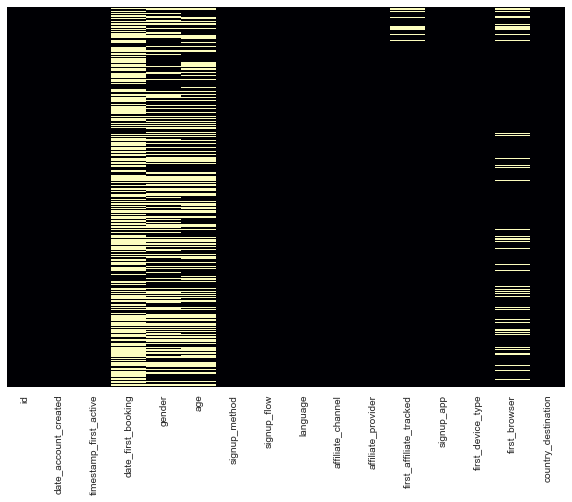

In [13]:
# For all my columns in the user table, visualize which ones have missing values
plt.figure(figsize= (10,7))
sns.heatmap(users.isnull(),yticklabels= False,cbar= False, cmap= 'magma');

Unfortunately, age and gender have quite a bit of missing values (in yellow). This is unfortunate since both columns I suspect hold some predictive power on the target variable. Down the line, I will think more closely about how to impute these values. For now, I'll remove them. That would cut my dataset from over 200K observations to a bit over 100K observations.

In [14]:
print('Percent of instances with missing values for gender:')
(users[users['gender'].isnull()]['id'].count() / users['id'].count())*100

Percent of instances with missing values for gender:


44.829023991454712

In [15]:
print('Percent of instances with missing values for age:')
(users[users['age'].isnull()]['id'].count() / users['id'].count())*100

Percent of instances with missing values for age:


41.222575673105304

In [16]:
# Clean up the gender column
users.loc[users['gender'].isin(['MALE', 'FEMALE']), 'gender'] = (users[users['gender']
                                                                      .isin(['MALE', 'FEMALE'])]['gender']
                                                                      .apply(lambda x: x.title()))

In [17]:
users.loc[users['gender'] == 'OTHER', 'gender'] = 'Other'

In [18]:
# Age imputation using the median
users.loc[users['age'].isnull(), 'age'] = users['age'].median()

In [19]:
# Bin ages
bins = list(np.arange(15, 90, 5))
bins.insert(0,0)
bins.append(int(users['age'].max()))
bin_vals = ['less_than_15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50',
                   '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', 'more_than_85']

users['age_bucket'] = pd.cut(users['age'], bins, labels= bin_vals)

In [20]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bucket
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,30-35
1,820tgsjxq7,2011-05-25,20090523174809,NaN,Male,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,35-40
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,Female,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,55-60
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,Female,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,40-45
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,40-45


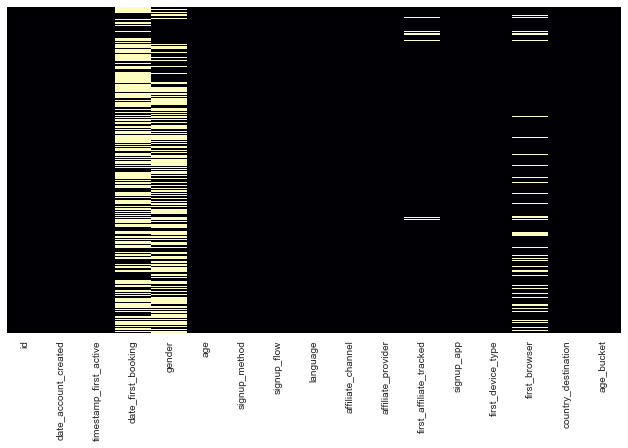

In [21]:
# Visualize my missing data once again
plt.figure(figsize= (11,6))
sns.heatmap(users.isnull(),yticklabels=False,cbar=False,cmap='magma');

In [22]:
# Drop less useful cols such as date_first_booking - this won't be helpful at the time of prediction
users = users.drop(['date_first_booking'], axis= 1)

In [23]:
users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bucket
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,30-35
1,820tgsjxq7,2011-05-25,20090523174809,Male,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,35-40
2,4ft3gnwmtx,2010-09-28,20090609231247,Female,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,55-60
3,bjjt8pjhuk,2011-12-05,20091031060129,Female,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,40-45
4,87mebub9p4,2010-09-14,20091208061105,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,40-45


In [24]:
# Make date_account_created col into datetime
users['date_account_created'] = pd.to_datetime(users['date_account_created'])

# Make timestamp_first_active into a datetime
users['timestamp_first_active'] = users['timestamp_first_active'].apply(lambda x: str(x)[:8])
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d', errors='ignore')

# Calculate new column with the time between account creation and when the user is first active
users['active_created_duration'] = (users['date_account_created'] - users['timestamp_first_active']).dt.days

# Create month and year cols
users['year_created'] = pd.DatetimeIndex(users['date_account_created']).year
users['month_created'] = pd.DatetimeIndex(users['date_account_created']).month

In [25]:
# Rearrange order of columsn
cols_reord = ['id', 'date_account_created', 'year_created', 'month_created', 'timestamp_first_active',
              'active_created_duration', 'gender', 'age','age_bucket', 'signup_method', 'signup_flow', 'language',
              'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
              'country_destination']

users = users[cols_reord]
users.head()

,id,date_account_created,year_created,month_created,timestamp_first_active,active_created_duration,gender,age,age_bucket,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2010,6,2009-03-19,466,NaN,34.0,30-35,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2011,5,2009-05-23,732,Male,38.0,35-40,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2010,9,2009-06-09,476,Female,56.0,55-60,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2011,12,2009-10-31,765,Female,42.0,40-45,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2010,9,2009-12-08,280,NaN,41.0,40-45,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Features Exploration

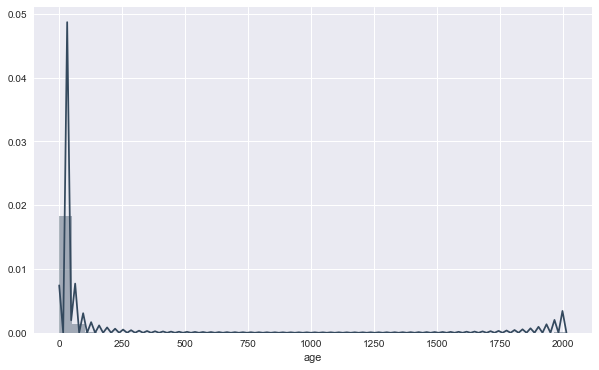

In [26]:
# Visualize the overall distribution of ages
plt.figure(figsize= (10, 6))
sns.distplot(users['age'], bins= 40, color= '#34495e');

Looks like there is a crazy distribution - it's extremely skewed to the right. I'll explore this a bit more.

In [27]:
# What's the max age in the data set?
users['age'].max()

2014.0

In [28]:
# How many users are over the age of 100?
users[users['age'] >= 90].count()

id                         2561
date_account_created       2561
year_created               2561
month_created              2561
timestamp_first_active     2561
active_created_duration    2561
gender                     1841
age                        2561
age_bucket                 2561
signup_method              2561
signup_flow                2561
language                   2561
affiliate_channel          2561
affiliate_provider         2561
first_affiliate_tracked    2509
signup_app                 2561
first_device_type          2561
first_browser              2391
country_destination        2561
dtype: int64

In [29]:
# Over 2300 observations have a strange age. Will do a simple -1 imputation for these
# median_age = users['age'].median()
users.loc[(users['age'] >= 90) | (users['age'] < 16), 'age'] = -1 

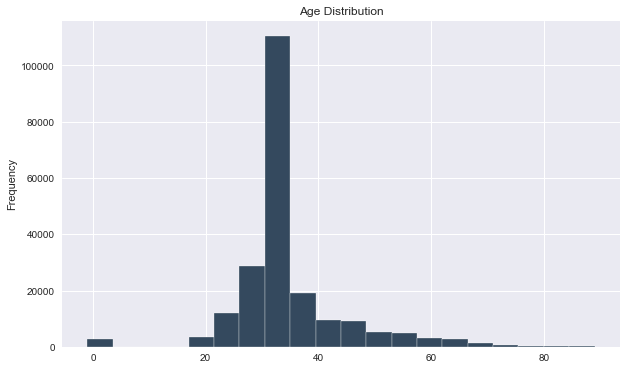

In [30]:
# Trying this again. Visualizing the overall distribution of ages
fig, ax = plt.subplots(figsize= (10, 6))
users['age'].plot(kind= 'hist', bins= 20, edgecolor= 'white', color= "#34495e")

ax.set_title('Age Distribution');

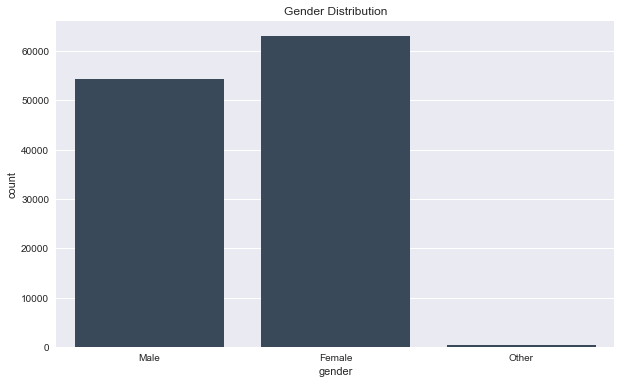

In [31]:
# Plot the count of sexes
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'gender', data= users, palette= ["#34495e"], ax= ax)

ax.set_title('Gender Distribution');

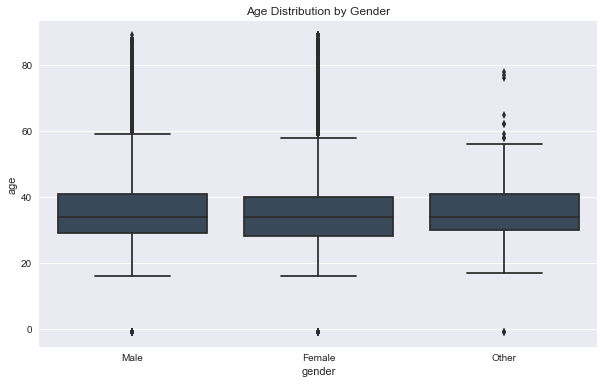

In [32]:
# Visualize the distribution of age for the different sexes
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'gender', y= 'age', data= users[users['gender'].isin(['Male', 'Female', 'Other'])], palette= ["#34495e"], ax= ax)

ax.set_title('Age Distribution by Gender');

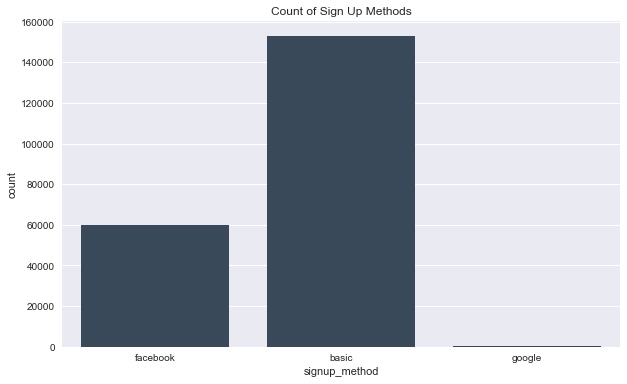

In [33]:
'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 6))

sns.countplot(x= 'signup_method', data= clean_users, palette= ["#34495e"], ax= ax1)
ax1.set_title('Count of Sign Up Methods (clean_users df)')

sns.countplot(x= 'signup_method', data= users, palette= ["#34495e"], ax= ax2)
ax2.set_title('Count of Sign Up Methods (users df)');
'''
fig, ax = plt.subplots(1, 1, figsize= (10, 6))

sns.countplot(x= 'signup_method', data= users, palette= ["#34495e"], ax= ax)
ax.set_title('Count of Sign Up Methods');

If I swap the clean_users data frame for the users dataframe, I can clearly see I've introduced some bias to my data. I'll have to think about this more prior to running predictive models.


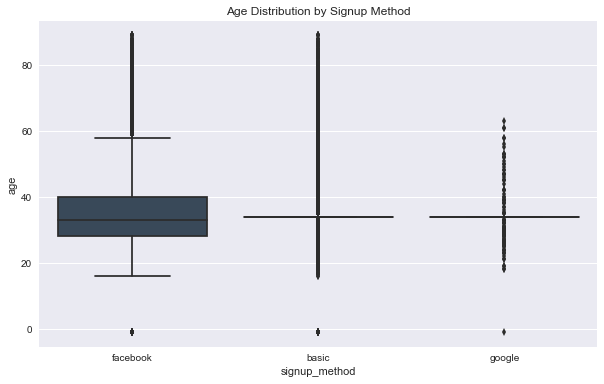

In [34]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'signup_method', y= 'age', data= users, palette= ["#34495e", "#3498db", "#95a5a6"], ax= ax)

ax.set_title('Age Distribution by Signup Method');

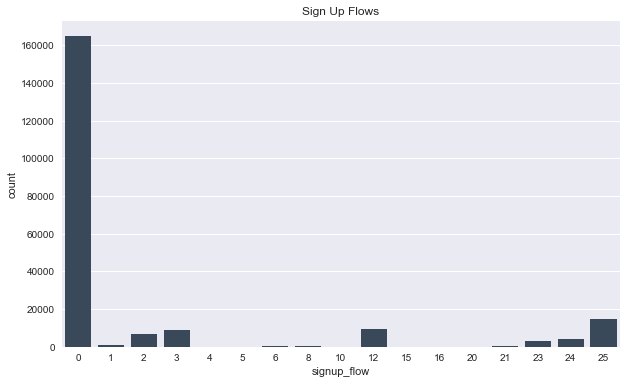

In [35]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'signup_flow', data= users, palette= ["#34495e"], ax= ax,)

ax.set_title('Sign Up Flows');

Seems like most people come from sign up flow '0'. Several users sign up on 3, 12, and 25. Not exactly sure if this is a different sign up form or it's the pages navigated prior to signing up, but it could hold some predictive power.

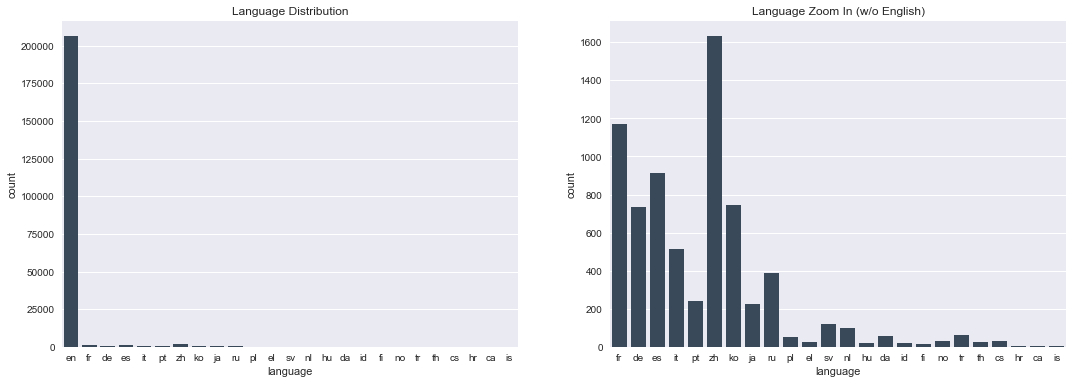

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 6))
sns.countplot(x= 'language', data= users, palette= ["#34495e"], ax= ax1)
ax1.set_title('Language Distribution')

sns.countplot(x= 'language', data= users[users['language'] != 'en'] , palette= ["#34495e"], ax= ax2);
ax2.set_title('Language Zoom In (w/o English)');

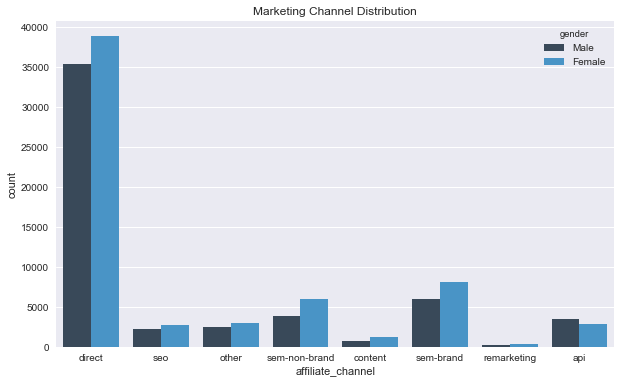

In [37]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'affiliate_channel', hue= 'gender', data= users[users['gender'] != 'Other'], palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title("Marketing Channel Distribution");

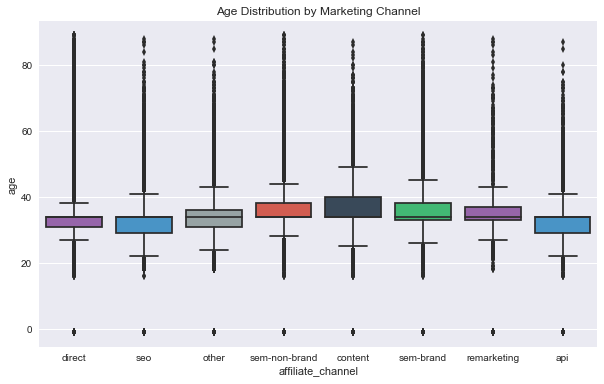

In [38]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'affiliate_channel', y= 'age', data= users, 
            palette= ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
            ax= ax)

ax.set_title('Age Distribution by Marketing Channel');

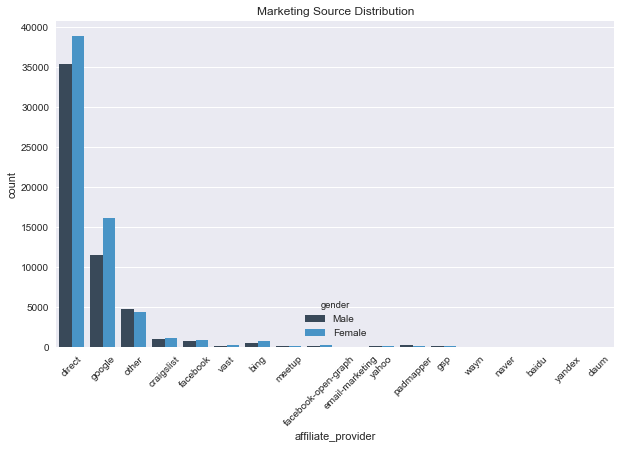

In [39]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'affiliate_provider', hue= 'gender', data= users[users['gender'] != 'Other'], palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('Marketing Source Distribution')
plt.xticks(rotation= 45);

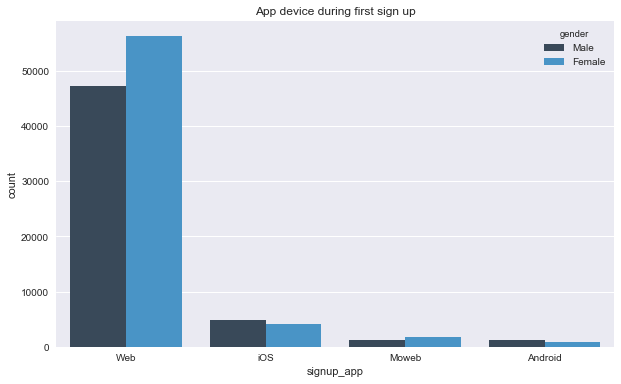

In [40]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.countplot(x= 'signup_app', hue= 'gender', data= users[users['gender'] != 'Other'], palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('App device during first sign up');

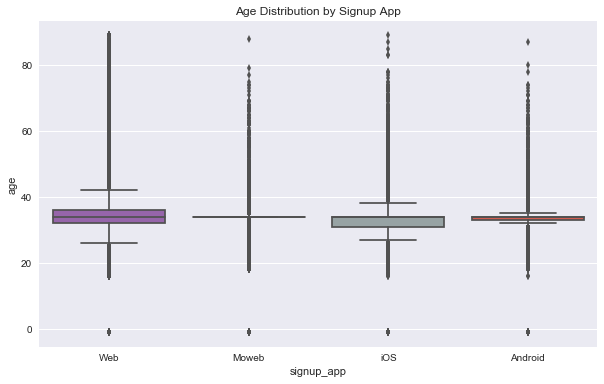

In [41]:
fig, ax = plt.subplots(figsize= (10, 6))
sns.boxplot(x= 'signup_app', y= 'age', data= users, 
            palette= ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
            ax= ax)

ax.set_title('Age Distribution by Signup App');

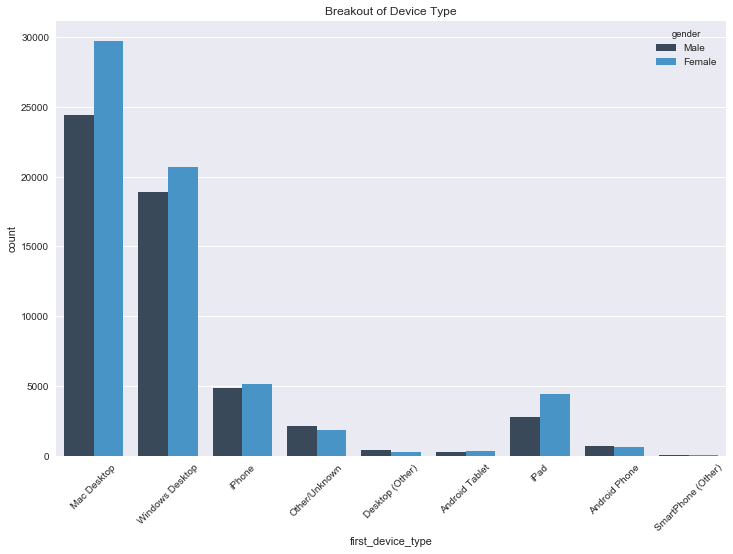

In [42]:
fig, ax = plt.subplots(figsize= (12, 8))
sns.countplot(x= 'first_device_type', hue= 'gender', data= users[users['gender'] != 'Other'], palette= ["#34495e", "#3498db"], ax= ax)

ax.set_title('Breakout of Device Type')
plt.xticks(rotation= 45);

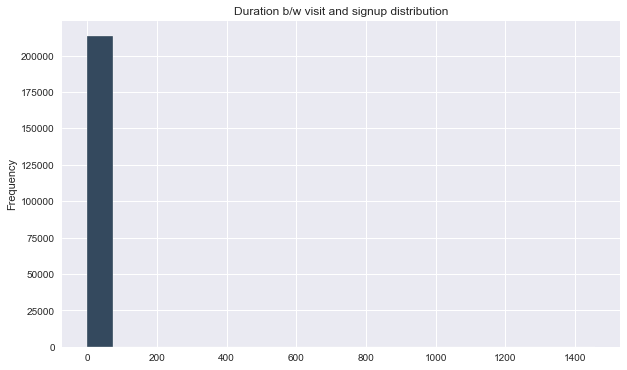

In [43]:
fig, ax = plt.subplots(figsize= (10, 6))
users['active_created_duration'].plot(kind= 'hist', bins= 20, edgecolor= 'white', color= "#34495e")

ax.set_title('Duration b/w visit and signup distribution');

### Target Variable Exploration

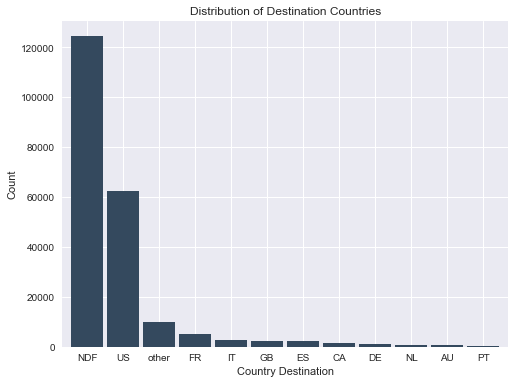

In [44]:
# Look at distribution of target variable
fig, ax = plt.subplots(figsize= (8,6))
users['country_destination'].value_counts().plot(kind= 'bar', ax= ax, color= ['#34495e'], width= 0.9)

ax.set_xlabel('Country Destination')
ax.set_title('Distribution of Destination Countries')
plt.xticks(rotation= 0)
ax.set_ylabel('Count');

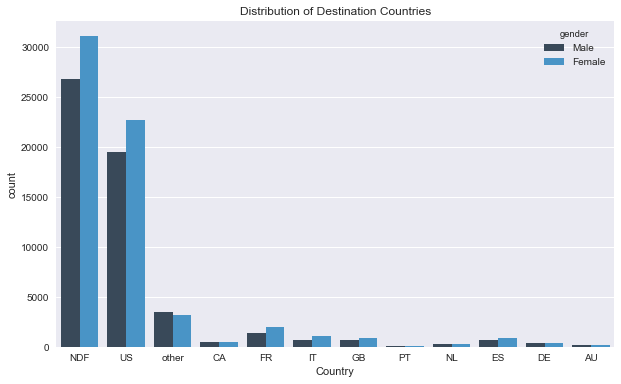

In [45]:
# Look at distribution of target variable
fig, ax = plt.subplots(figsize= (10,6))
sns.countplot(x= 'country_destination', hue= 'gender', data= users[users['gender'].isin(['Male', 'Female'])], palette= ["#34495e", "#3498db"], ax= ax)

ax.set_xlabel('Country')
ax.set_title('Distribution of Destination Countries')
plt.xticks(rotation= 0);

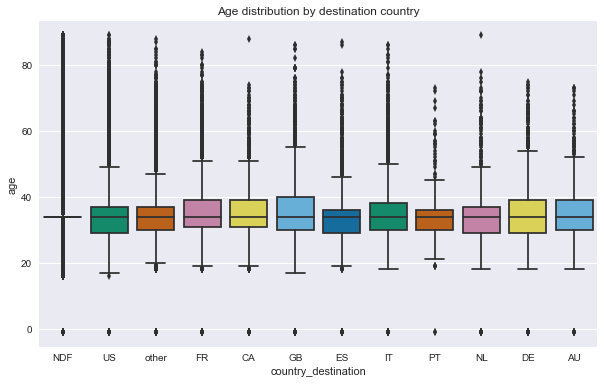

In [46]:
# Distribution of ages for the different destinations
fig, ax = plt.subplots(figsize= (10,6))
sns.boxplot(x= 'country_destination', y= 'age', palette= 'colorblind', data= users, ax= ax)

ax.set_title('Age distribution by destination country');

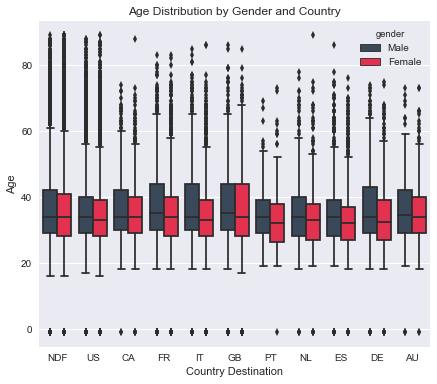

In [47]:
# Adding a gender dimension
fig, ax = plt.subplots(figsize= (7,6))
sns.boxplot(x= 'country_destination', y= 'age', hue= 'gender', 
               palette= ["#34495e", "#FF153D"], data= users[(users['gender'].isin(['Male', 'Female']))&(users['country_destination'] !='other')], ax= ax)

ax.set_title('Age Distribution by Gender and Country')
ax.set_xlabel('Country Destination')
ax.set_ylabel('Age');

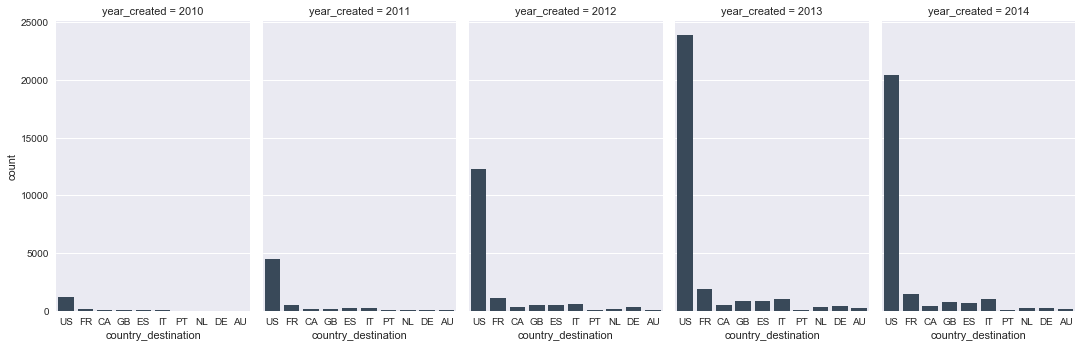

In [49]:
# Look at the evolution of destination countries by year. Big ramp up of volume as part of Airbnb's growth
sns.factorplot(x="country_destination",
               col="year_created", 
               data=users[~users['country_destination'].isin(['NDF','other'])], 
               kind="count", 
               palette= ["#34495e"], 
               size=5, 
               aspect=.6);

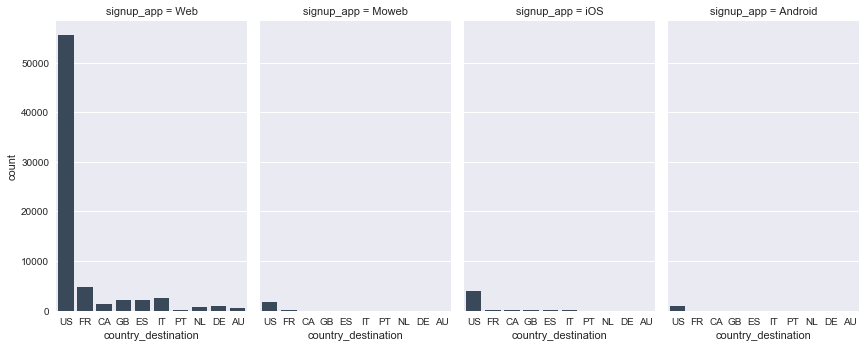

In [50]:
sns.factorplot(x="country_destination",
               col="signup_app", 
               data=users[~users['country_destination'].isin(['NDF','other'])], 
               kind="count", 
               palette= ["#34495e"], 
               size=5, 
               aspect=.6);

In [51]:
users.head()

,id,date_account_created,year_created,month_created,timestamp_first_active,active_created_duration,gender,age,age_bucket,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2010,6,2009-03-19,466,NaN,34.0,30-35,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2011,5,2009-05-23,732,Male,38.0,35-40,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2010,9,2009-06-09,476,Female,56.0,55-60,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2011,12,2009-10-31,765,Female,42.0,40-45,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2010,9,2009-12-08,280,NaN,41.0,40-45,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [52]:
# Storing this table as a separate file for ML modeling
users.to_csv('../data/users_clean.csv', index= False)

### Sessions Table

In [53]:
sessions.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [54]:
len(sessions)

10567737

In [55]:
sessions.device_type.value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [56]:
# Create a pivot table so that each column is a device used, and sum up total time on that device
pivoted_device = (pd.pivot_table(sessions,
                      index= ['user_id'],
                      columns= ['device_type'],
                      values= 'secs_elapsed',
                      aggfunc= lambda x: len(x.unique()),
                      fill_value= 0)
                      .reset_index())

In [57]:
pivoted_device.head()

device_type,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,00023iyk9l,0,0,0,0,0,0,35,0,0,0,0,0,4,0
1,0010k6l0om,0,0,0,0,0,0,60,0,0,0,0,0,0,0
2,001wyh0pz8,0,87,0,0,0,0,0,0,0,0,0,0,0,0
3,0028jgx1x1,30,0,1,0,0,0,0,0,0,0,0,0,0,0
4,002qnbzfs5,14,0,0,0,0,0,0,0,0,0,0,0,598,0


In [58]:
sessions.action.value_counts()

show                           2768278
index                           843699
search_results                  725226
personalize                     706824
search                          536057
ajax_refresh_subtotal           487744
update                          365130
similar_listings                364624
social_connections              339000
reviews                         320591
active                          188036
similar_listings_v2             168788
lookup                          162041
create                          155887
dashboard                       152952
header_userpic                  141830
collections                     124417
edit                            109083
campaigns                       105028
track_page_view                  81117
unavailabilities                 78317
qt2                              64651
notifications                    59392
confirm_email                    58726
requested                        57034
identity                 

In [59]:
count_of_action_types = (pd.pivot_table(sessions,
                      index= ['user_id'],
                      columns= ['action_type'],
                      values= 'secs_elapsed',
                      aggfunc= len,
                      fill_value= 0)
                      .reset_index())

In [60]:
count_of_action_types.head()

action_type,user_id,-unknown-,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view
0,00023iyk9l,0,1,0,4,9,1,0,1,0,21
1,0010k6l0om,5,0,0,16,9,0,0,1,0,17
2,001wyh0pz8,6,0,0,66,2,0,0,0,3,8
3,0028jgx1x1,1,0,0,9,5,0,0,0,1,15
4,002qnbzfs5,184,1,0,140,140,16,0,0,15,216


In [61]:
key_action_types = count_of_action_types[['user_id', 'view', 'click', 'data', 'submit', 'booking_request']].copy()

In [62]:
key_action_types.head()

action_type,user_id,view,click,data,submit,booking_request
0,00023iyk9l,21,4,9,0,1
1,0010k6l0om,17,16,9,0,0
2,001wyh0pz8,8,66,2,3,0
3,0028jgx1x1,15,9,5,1,0
4,002qnbzfs5,216,140,140,15,1


In [63]:
# Calculate some conversion rates - this could be a useful signal regarding which is a 'higher quality' user
key_action_types['click_through_rate'] = key_action_types['click'] / key_action_types['view'] 
key_action_types['cvr1'] = key_action_types['submit'] / key_action_types['click']
key_action_types['cvr2'] = key_action_types['booking_request'] / key_action_types['click']

In [64]:
key_action_types.head()

action_type,user_id,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,00023iyk9l,21,4,9,0,1,0.190476,0.000000,0.250000
1,0010k6l0om,17,16,9,0,0,0.941176,0.000000,0.000000
2,001wyh0pz8,8,66,2,3,0,8.250000,0.045455,0.000000
3,0028jgx1x1,15,9,5,1,0,0.600000,0.111111,0.000000
4,002qnbzfs5,216,140,140,15,1,0.648148,0.107143,0.007143


In [65]:
# Inner join the two new session-based tables together
pivoted_session_data = pd.merge(pivoted_device, key_action_types, how= 'inner', on= 'user_id')
pivoted_session_data.head(10)

,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,...,iPhone,iPodtouch,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,00023iyk9l,0,0,0,0,0,0,35,0,0,...,4,0,21,4,9,0,1,0.190476,0.000000,0.250000
1,0010k6l0om,0,0,0,0,0,0,60,0,0,...,0,0,17,16,9,0,0,0.941176,0.000000,0.000000
2,001wyh0pz8,0,87,0,0,0,0,0,0,0,...,0,0,8,66,2,3,0,8.250000,0.045455,0.000000
3,0028jgx1x1,30,0,1,0,0,0,0,0,0,...,0,0,15,9,5,1,0,0.600000,0.111111,0.000000
4,002qnbzfs5,14,0,0,0,0,0,0,0,0,...,598,0,216,140,140,15,1,0.648148,0.107143,0.007143
5,0031awlkjq,0,0,0,0,0,0,0,0,0,...,8,0,3,0,1,0,0,0.000000,NaN,NaN
6,0035hobuyj,0,0,0,0,0,0,447,0,0,...,0,0,55,206,41,4,0,3.745455,0.019417,0.000000
7,00378ocvlh,0,0,0,0,0,0,75,0,0,...,0,0,36,5,4,5,0,0.138889,1.000000,0.000000
8,00389675gq,0,0,17,0,0,0,0,0,0,...,0,0,74,22,34,8,0,0.297297,0.363636,0.000000
9,003iamz20l,0,0,0,0,0,0,0,0,0,...,0,0,59,47,43,1,0,0.796610,0.021277,0.000000


### Join user table with pivoted session data

In [66]:
data = pd.merge(users, pivoted_session_data, how= 'left', left_on= ['id'], right_on= ['user_id'])

In [67]:
data.head()

,id,date_account_created,year_created,month_created,timestamp_first_active,active_created_duration,gender,age,age_bucket,signup_method,...,iPhone,iPodtouch,view,click,data,submit,booking_request,click_through_rate,cvr1,cvr2
0,gxn3p5htnn,2010-06-28,2010,6,2009-03-19,466,NaN,34.0,30-35,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2011,5,2009-05-23,732,Male,38.0,35-40,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2010,9,2009-06-09,476,Female,56.0,55-60,basic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2011,12,2009-10-31,765,Female,42.0,40-45,facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2010,9,2009-12-08,280,NaN,41.0,40-45,basic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
data.drop(['user_id','id'], axis= 1, inplace= True)

In [69]:
data = data[['date_account_created', 'year_created', 'month_created',
       'timestamp_first_active', 'active_created_duration', 'gender', 'age',
       'age_bucket', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'Android App Unknown Phone/Tablet', 'Android Phone', 'Blackberry',
       'Chromebook', 'Linux Desktop', 'Mac Desktop', 'Opera Phone', 'Tablet',
       'Windows Desktop', 'Windows Phone', 'iPad Tablet', 'iPhone',
       'iPodtouch', 'view', 'click', 'data', 'submit', 'booking_request',
       'click_through_rate', 'cvr1', 'cvr2', 'country_destination']]

In [70]:
print("Number of observations for the new dataframe is: ")
len(data)

Number of observations for the new dataframe is: 


213451

In [71]:
data.to_csv('../data/users_sessions.csv', index= False)